In [1]:
# install Pint if necessary
try:
  from pint import UnitRegistry
except ImportError:
  !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import basename, exists


def download(url):
  filename = basename(url)
  if not exists(filename):
    from urllib.request import urlretrieve
    local, _ = urlretrieve(url, filename)
    print('Downloaded ' + local)


download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [3]:
import pandas as pd
from modsim import *
import matplotlib.pyplot as plt
import numpy as np
import random

<h2> Menghapus kolom yang tidak diperlukan </h2>

In [4]:
# Menghapus kolom yang tidak diperlukan
data_have_index = [
  "sample/anxiety-disorders-males-vs-females.csv",
  "sample/bipolar-disorder-in-males-vs-females.csv",
  "sample/depression-males-vs-females.csv",
  "sample/eating-disorders-in-males-vs-females.csv",
  "sample/Mental health Depression disorder Data.csv",
  "sample/schizophrenia-in-males-vs-females.csv"
]

for file_path in data_have_index:
  df = pd.read_csv(file_path)
  if 'index' in df.columns:
    df = df.drop('index', axis=1)
  df.to_csv(file_path, index=False)

C:\Users\katana\AppData\Local\Temp\ipykernel_27840\2091496989.py:12: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
df = pd.read_csv("sample/anxiety-disorders-males-vs-females.csv")
df

,Entity,Code,Year,Prevalence - Anxiety disorders - Sex: Male - Age: Age-standardized (Percent),Prevalence - Anxiety disorders - Sex: Female - Age: Age-standardized (Percent),Population (historical estimates),Continent
0,Abkhazia,OWID_ABK,2015,NaN,NaN,NaN,Asia
1,Afghanistan,AFG,1990,3.556843,5.971172,12412311.0,NaN
2,Afghanistan,AFG,1991,3.548885,5.980482,13299016.0,NaN
3,Afghanistan,AFG,1992,3.542779,5.988175,14485543.0,NaN
4,Afghanistan,AFG,1993,3.538304,5.993858,15816601.0,NaN
...,...,...,...,...,...,...,...
56390,Zimbabwe,ZWE,1988,NaN,NaN,9849129.0,NaN
56391,Zimbabwe,ZWE,1989,NaN,NaN,10153852.0,NaN
56392,Zimbabwe,ZWE,2020,NaN,NaN,14862927.0,NaN
56393,Zimbabwe,ZWE,2021,NaN,NaN,15092171.0,NaN


<h2>Cleaning data bunuh diri</h2>

In [6]:
df_grouped_bundir = pd.read_csv("sample/suicide-rates-among-young-people.csv")
df_grouped_bundir = df_grouped_bundir.groupby('Year').mean().reset_index()
df_grouped_bundir

C:\Users\katana\AppData\Local\Temp\ipykernel_27840\4176330424.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped_bundir = df_grouped_bundir.groupby('Year').mean().reset_index()


,Year,"Death rate per 100,000 people - Cause: Self-harm - Sex: Both sexes - Age group: YEARS15-19","Death rate per 100,000 people - Cause: Self-harm - Sex: Both sexes - Age group: YEARS20-24","Death rate per 100,000 people - Cause: Self-harm - Sex: Both sexes - Age group: YEARS25-34"
0,2000,7.988028,13.170606,14.197090
1,2001,7.682564,12.826399,13.843077
2,2002,7.509885,12.572857,13.718074
3,2003,7.351542,12.392850,13.247862
4,2004,7.246225,12.214857,13.253322
5,2005,7.117822,12.229616,13.380470
6,2006,6.988251,11.861770,13.079855
7,2007,6.851540,11.609120,13.236811
8,2008,6.972660,11.270457,13.284965
9,2009,6.875445,11.334314,13.312598


In [7]:
df_grouped_bundir['Change_15_19'] = df_grouped_bundir[
  'Death rate per 100,000 people - Cause: Self-harm - Sex: Both sexes - Age group: YEARS15-19']
df_grouped_bundir['Change_20_24'] = df_grouped_bundir[
  'Death rate per 100,000 people - Cause: Self-harm - Sex: Both sexes - Age group: YEARS20-24']
df_grouped_bundir['Change_25_34'] = df_grouped_bundir[
  'Death rate per 100,000 people - Cause: Self-harm - Sex: Both sexes - Age group: YEARS25-34']

# Menghitung rata2 bunuh diri dari 300000 ribu orang pertahun.
df_grouped_bundir['Percentage_Bundir'] = ((df_grouped_bundir[
                                             'Death rate per 100,000 people - Cause: Self-harm - Sex: Both sexes - Age group: YEARS15-19'] +
                                           df_grouped_bundir[
                                             'Death rate per 100,000 people - Cause: Self-harm - Sex: Both sexes - Age group: YEARS20-24'] +
                                           df_grouped_bundir[
                                             'Death rate per 100,000 people - Cause: Self-harm - Sex: Both sexes - Age group: YEARS25-34']) / 300000) * 100

# print(f"Minimal: {df_grouped_bundir[['Percentage_Bundir']].min()}")
# print(f"Maximal: {df_grouped_bundir[['Percentage_Bundir']].max()}")
df_grouped_bundir['Percentage_Bundir']

0     0.011785
1     0.011451
2     0.011267
3     0.010997
4     0.010905
5     0.010909
6     0.010643
7     0.010566
8     0.010509
9     0.010507
10    0.010280
11    0.010131
12    0.010077
13    0.009819
14    0.009705
15    0.009465
16    0.009136
17    0.009122
18    0.008833
19    0.008697
Name: Percentage_Bundir, dtype: float64

# Step cleaning data

1. Proses cleaning data dengan memperiksa apakah file ada yang missing atau tidak.
2. Mengisi data yang kosong atau NaN dengan method ffill ( Mengisi nilai kosong berdasarkan nilai didepannya).
3. Melakukan perubahan nama dalam tabel.
4. Melakukan filter data dari berdasar kan tahun.
5. Melakukan group berdasarkan tahun. dan dicari mean pertahun.
6. Step terakhir dijumlahkan mean female dan male.

<h3>Anxiety</h3>

In [8]:
df_anxiety = pd.read_csv("sample/anxiety-disorders-males-vs-females.csv")
df_anxiety.isnull().sum().sum()

158275

In [9]:
df_anxiety = df_anxiety.fillna(method='ffill')
df_anxiety.isnull().sum().sum()

3

In [10]:
df_anxiety = df_anxiety.rename(
  columns={'Prevalence - Anxiety disorders - Sex: Female - Age: Age-standardized (Percent)': 'Anxiety_Female',
           'Prevalence - Anxiety disorders - Sex: Male - Age: Age-standardized (Percent)': 'Anxiety_Male'})

df_anxiety_filtered = df_anxiety[(df_anxiety['Year'] >= 1990) & (df_anxiety['Year'] <= 2017)]

df_anxiety_mean = df_anxiety_filtered.groupby('Year').agg({
  'Anxiety_Male': 'mean',
  'Anxiety_Female': 'mean'
})

total_df_anxiety_mean = df_anxiety_mean['Anxiety_Female'] + df_anxiety_mean['Anxiety_Male']

total_df_anxiety_mean

Year
1990    8.597020
1991    8.577117
1992    8.580791
1993    8.584431
1994    8.587703
1995    8.590236
1996    8.597522
1997    8.612425
1998    8.630520
1999    8.647335
2000    8.681072
2001    8.686826
2002    8.691382
2003    8.695295
2004    8.699017
2005    8.702923
2006    8.713647
2007    8.733901
2008    8.757902
2009    8.779832
2010    8.793758
2011    8.802289
2012    8.811699
2013    8.821406
2014    8.830757
2015    8.813362
2016    8.843971
2017    8.847163
dtype: float64

<h3>Bipolar</h3>

In [11]:
df_bipolar = pd.read_csv("sample/bipolar-disorder-in-males-vs-females.csv")
df_bipolar.isnull().sum()

Entity                                                                               0
Code                                                                              2316
Year                                                                                 0
Prevalence - Bipolar disorder - Sex: Male - Age: Age-standardized (Percent)      49555
Prevalence - Bipolar disorder - Sex: Female - Age: Age-standardized (Percent)    49555
Population (historical estimates)                                                  739
Continent                                                                        56110
dtype: int64

In [12]:
df_bipolar = df_bipolar.fillna(method='ffill')
df_bipolar.isnull().sum()

Entity                                                                           0
Code                                                                             0
Year                                                                             0
Prevalence - Bipolar disorder - Sex: Male - Age: Age-standardized (Percent)      1
Prevalence - Bipolar disorder - Sex: Female - Age: Age-standardized (Percent)    1
Population (historical estimates)                                                1
Continent                                                                        0
dtype: int64

In [13]:
df_bipolar = df_bipolar.rename(
  columns={'Prevalence - Bipolar disorder - Sex: Male - Age: Age-standardized (Percent)': 'Bipolar_Male',
           'Prevalence - Bipolar disorder - Sex: Female - Age: Age-standardized (Percent)': 'Bipolar_Female'})

df_bipolar_filtered = df_bipolar[(df_bipolar['Year'] >= 1990) & (df_bipolar['Year'] <= 2017)]

df_bipolar_mean = df_bipolar_filtered.groupby('Year').agg({
  'Bipolar_Male': 'mean',
  'Bipolar_Female': 'mean'
})

total_df_bipolar_mean = df_bipolar_mean['Bipolar_Male'] + df_bipolar_mean['Bipolar_Female']

total_df_bipolar_mean

Year
1990    1.352318
1991    1.349416
1992    1.349923
1993    1.350428
1994    1.350914
1995    1.351366
1996    1.351799
1997    1.352259
1998    1.352736
1999    1.353219
2000    1.357046
2001    1.357960
2002    1.359527
2003    1.361330
2004    1.362937
2005    1.363902
2006    1.364416
2007    1.364993
2008    1.365593
2009    1.366167
2010    1.366647
2011    1.367089
2012    1.367591
2013    1.368116
2014    1.368614
2015    1.353710
2016    1.369390
2017    1.369737
dtype: float64

<h3>Depression</h3>

In [14]:
df_depression = pd.read_csv("sample/depression-males-vs-females.csv")
df_depression.isnull().sum()

Entity                                                                                   0
Code                                                                                  2316
Year                                                                                     0
Prevalence - Depressive disorders - Sex: Male - Age: Age-standardized (Percent)      49555
Prevalence - Depressive disorders - Sex: Female - Age: Age-standardized (Percent)    49555
Population (historical estimates)                                                      739
Continent                                                                            56110
dtype: int64

In [15]:
df_depression = df_depression.fillna(method='ffill')
df_depression.isnull().sum()

Entity                                                                               0
Code                                                                                 0
Year                                                                                 0
Prevalence - Depressive disorders - Sex: Male - Age: Age-standardized (Percent)      1
Prevalence - Depressive disorders - Sex: Female - Age: Age-standardized (Percent)    1
Population (historical estimates)                                                    1
Continent                                                                            0
dtype: int64

In [16]:
df_depression = df_depression.rename(
  columns={'Prevalence - Depressive disorders - Sex: Female - Age: Age-standardized (Percent)': 'Depression_Female',
           'Prevalence - Depressive disorders - Sex: Male - Age: Age-standardized (Percent)': 'Depression_Male'})

df_depression_filtered = df_depression[(df_depression['Year'] >= 1990) & (df_depression['Year'] <= 2017)]

df_depression_mean = df_depression_filtered.groupby('Year').agg({
  'Depression_Male': 'mean',
  'Depression_Female': 'mean'
})

total_df_depression_mean = df_depression_mean['Depression_Male'] + df_depression_mean['Depression_Female']

total_df_depression_mean

Year
1990    7.915004
1991    7.908606
1992    7.908812
1993    7.909289
1994    7.910118
1995    7.911336
1996    7.915877
1997    7.924723
1998    7.934348
1999    7.941495
2000    7.948691
2001    7.944271
2002    7.936789
2003    7.927226
2004    7.916698
2005    7.906221
2006    7.889664
2007    7.863942
2008    7.835988
2009    7.812121
2010    7.798328
2011    7.793087
2012    7.789183
2013    7.786809
2014    7.785408
2015    7.738691
2016    7.784694
2017    7.785131
dtype: float64

<h3>Schizo</h3>

In [17]:
df_schizo = pd.read_csv('sample/schizophrenia-in-males-vs-females.csv')
df_schizo.isnull().sum()

Entity                                                                            0
Code                                                                           2316
Year                                                                              0
Prevalence - Schizophrenia - Sex: Male - Age: Age-standardized (Percent)      49555
Prevalence - Schizophrenia - Sex: Female - Age: Age-standardized (Percent)    49555
Population (historical estimates)                                               739
Continent                                                                     56110
dtype: int64

In [18]:

df_schizo = df_schizo.fillna(method='ffill')
df_schizo.isnull().sum()

Entity                                                                        0
Code                                                                          0
Year                                                                          0
Prevalence - Schizophrenia - Sex: Male - Age: Age-standardized (Percent)      1
Prevalence - Schizophrenia - Sex: Female - Age: Age-standardized (Percent)    1
Population (historical estimates)                                             1
Continent                                                                     0
dtype: int64

In [19]:
df_schizo = df_schizo.rename(
  columns={'Prevalence - Schizophrenia - Sex: Female - Age: Age-standardized (Percent)': 'Schizo_Female',
           'Prevalence - Schizophrenia - Sex: Male - Age: Age-standardized (Percent)': 'Schizo_Male'})

df_schizo_filtered = df_schizo[(df_schizo['Year'] >= 1990) & (df_schizo['Year'] <= 2017)]

df_schizo_mean = df_schizo_filtered.groupby('Year').agg({
  'Schizo_Male': 'mean',
  'Schizo_Female': 'mean'
})

total_df_schizo_mean = df_schizo_mean['Schizo_Male'] + df_schizo_mean['Schizo_Female']

total_df_schizo_mean

Year
1990    0.559838
1991    0.559168
1992    0.559488
1993    0.559778
1994    0.560027
1995    0.560216
1996    0.560337
1997    0.560431
1998    0.560538
1999    0.560697
2000    0.561934
2001    0.562433
2002    0.563225
2003    0.564135
2004    0.564976
2005    0.565553
2006    0.565996
2007    0.566533
2008    0.567094
2009    0.567608
2010    0.567997
2011    0.568386
2012    0.568903
2013    0.569459
2014    0.569963
2015    0.569491
2016    0.570701
2017    0.571070
dtype: float64

## Eating

In [20]:
df_eating = pd.read_csv("sample/eating-disorders-in-males-vs-females.csv")
df_eating.isnull().sum()

Entity                                                                               0
Code                                                                              2316
Year                                                                                 0
Prevalence - Eating disorders - Sex: Male - Age: Age-standardized (Percent)      49555
Prevalence - Eating disorders - Sex: Female - Age: Age-standardized (Percent)    49555
Population (historical estimates)                                                  739
Continent                                                                        56110
dtype: int64

In [21]:
df_eating = df_eating.fillna(method='ffill')
df_eating.isnull().sum()

Entity                                                                           0
Code                                                                             0
Year                                                                             0
Prevalence - Eating disorders - Sex: Male - Age: Age-standardized (Percent)      1
Prevalence - Eating disorders - Sex: Female - Age: Age-standardized (Percent)    1
Population (historical estimates)                                                1
Continent                                                                        0
dtype: int64

In [22]:
df_eating = df_eating.rename(
  columns={'Prevalence - Eating disorders - Sex: Male - Age: Age-standardized (Percent)': 'Eating_Male',
           'Prevalence - Eating disorders - Sex: Female - Age: Age-standardized (Percent)': 'Eating_Female'})

df_eating_filtered = df_eating[(df_eating['Year'] >= 1990) & (df_eating['Year'] <= 2017)]

df_eating_mean = df_eating_filtered.groupby('Year').agg({
  'Eating_Male': 'mean',
  'Eating_Female': 'mean'
})

total_df_eating_mean = df_eating_mean['Eating_Male'] + df_eating_mean['Eating_Female']

total_df_eating_mean

Year
1990    0.405316
1991    0.403811
1992    0.404357
1993    0.405005
1994    0.405724
1995    0.406447
1996    0.407409
1997    0.408697
1998    0.410193
1999    0.411900
2000    0.415521
2001    0.417927
2002    0.421073
2003    0.424638
2004    0.428115
2005    0.431091
2006    0.433939
2007    0.437272
2008    0.440761
2009    0.443965
2010    0.446655
2011    0.448924
2012    0.451192
2013    0.453310
2014    0.455500
2015    0.447271
2016    0.461217
2017    0.464348
dtype: float64

In [23]:
# dictionary yang memetakan setiap penyakit mental ke rentang prevalensinya (dalam persentase) untuk laki-laki dan perempuan.
# Nilai-nilai ini diambil dari data diatas diambil terkecil dan terbesar..
prevalence_range = {
  'schizophrenia': {'male': (total_df_schizo_mean.min(), total_df_schizo_mean.max()),
                    'female': (total_df_schizo_mean.min(), total_df_schizo_mean.max())},
  'anxiety': {'male': (total_df_anxiety_mean.min(), total_df_anxiety_mean.max()),
              'female': (total_df_anxiety_mean.min(), total_df_anxiety_mean.max())},
  'bipolar': {'male': (total_df_bipolar_mean.min(), total_df_bipolar_mean.max()),
              'female': (total_df_bipolar_mean.min(), total_df_bipolar_mean.max())},
  'eating_disorders': {'male': (total_df_eating_mean.min(), total_df_eating_mean.max()),
                       'female': (total_df_eating_mean.min(), total_df_eating_mean.max())},
  'depression': {'male': (total_df_depression_mean.min(), total_df_depression_mean.max()),
                 'female': (total_df_depression_mean.min(), total_df_depression_mean.max())},
}

# asumsi penyakit mental ke probabilitas bunuh diri yang terkait
suicide_risk = {
  'schizophrenia': 0.1,
  'anxiety': 0.05,
  'bipolar': 0.08,
  'eating_disorders': 0.02,
  'depression': 0.07,
}

populations = [(489128, 350000)]

In [24]:
# System
system = System(prevalence_range=prevalence_range, suicide_risk=suicide_risk, num_points=random.randint(3, 23),
                iterations=1000)
# State
state = State(results_male=[], results_female=[], populations=populations, predictions=[])

## Monte Carlo simulation
Penjelasan:

1. Setelah looping menginisialisasikan `min_val` dan `max_val` yang diambil dari hasil menghitung rata2 penyakit mental dari 100 ribu orang pertahunnya.
2. `preval_values` akan memiliki sebuah array yang dimulai dari `min_val` sampai `max_val` dengan panjang `system.num_points`.
3. `num_male_with_disease` menghitung jumlah laki laki atau permupan dengan penyakit saat ini. Dengan asumsi populasi dan `preval_value` dipilih secara acak. Nilai akan dikalikan dan dibagi 100.
4. `num_suicide_male` mensimulasikan jumlah kasus bunuuh diri diantara laki2 atau perempuan saat ini. Binomial akan menghasilkan bilangan acak pada kasus bunuh diri berdasarkan distribusi yang diberikan

In [25]:
def run_simulation(state, system):
  total_suicide_male = 0
  total_suicide_female = 0

  # Simulasi untuk laki-laki
  for disease in system.prevalence_range.keys():
    min_val, max_val = system.prevalence_range[disease]['male']
    preval_values = np.linspace(min_val, max_val, system.num_points)
    num_male_with_disease = int(pop_male * np.random.choice(preval_values) / 100)
    num_suicide_male = np.random.binomial(num_male_with_disease, system.suicide_risk[disease])
    total_suicide_male += num_suicide_male

  # Simulasi untuk perempuan
  for disease in system.prevalence_range.keys():
    min_val, max_val = system.prevalence_range[disease]['female']
    preval_values = np.linspace(min_val, max_val, system.num_points)
    num_female_with_disease = int(pop_female * np.random.choice(preval_values) / 100)
    num_suicide_female = np.random.binomial(num_female_with_disease, system.suicide_risk[disease])
    total_suicide_female += num_suicide_female

  return total_suicide_male, total_suicide_female

## Sweepseries

Fungsi `run_simulation_sweepseries()` bekerja sama dengan run simulation diatas, akan tetapi disini untuk probabilitas dan populasi sudah dideklarasikan. </br>
    
Parameter: </br>
p1: PRobabilitass kematian </br>
system: Tempat menyimpan variabel contatnt. </br>
pop_male & pop_female: populasi laki2 dan perempuan.  </br>

In [26]:
def run_simulation_sweepseries(p1, system, pop_male, pop_female):
 
  state = State(total_suicide_male=0, total_suicide_female=0, total_alive_male=pop_male, total_alive_female=pop_female)

  for disease in system.prevalence_range.keys():
    num_male_with_disease = int(state.total_alive_male * p1 / 100)
    state.total_suicide_male += np.random.binomial(num_male_with_disease, system.suicide_risk[disease])

    num_female_with_disease = int(state.total_alive_female * p1 / 100)
    state.total_suicide_female += np.random.binomial(num_female_with_disease, system.suicide_risk[disease])

  return state

## Sweepseries run simulation

Mensimulasikan dan memplot angka bunuh diri pria berdasarkan berbagai tingkat prevalensi penyakit schizophrenia dalam populasi. Dimulai dengan menetapkan populasi pria (200.000) dan wanita (350.000), serta membuat array p1_array yang berisi 55 nilai prevalensi schizophrenia dari yang terendah hingga tertinggi. 

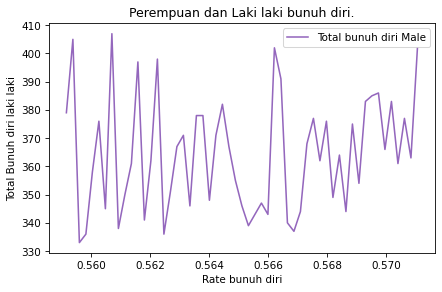

In [27]:
pop_male, pop_female = 200000, 350000
p1_array = np.linspace(total_df_schizo_mean.min(), total_df_schizo_mean.max(), 55)

sweep_male = SweepSeries()

for p1 in p1_array:
  final_state = run_simulation_sweepseries(p1, system, pop_male, pop_female)
  sweep_male[p1] = final_state.total_suicide_male

  # print(sweep)

sweep_male.plot(label="Total bunuh diri Male", color="C4")
decorate(title='Perempuan dan Laki laki bunuh diri.',
         xlabel='Rate bunuh diri',
         ylabel='Total Bunuh diri laki laki')

## Timeseries
Timeseries ini menunjukan jumlah kasus bunuh diri yang disimulasikan untuk laki-laki dan perempuan selama jumlah iterasi yang ditentukan (1000).

In [28]:
def run_simulation_timeseries(state, system):
  totals = TimeSeries()
  for i in range(system.iterations):
    simulations = run_simulation(state, system)
    totals[i] = (simulations[0], simulations[1])
  return totals

In [29]:
result_timeseries_male = run_simulation_timeseries(state, system)
show(result_timeseries_male)

,Quantity
Time,
0,"(2208, 4111)"
1,"(2353, 4139)"
2,"(2406, 4170)"
3,"(2277, 4113)"
4,"(2276, 4034)"
...,...
995,"(2278, 4146)"
996,"(2307, 4067)"
997,"(2254, 3947)"


## Runing monte carlo simulation

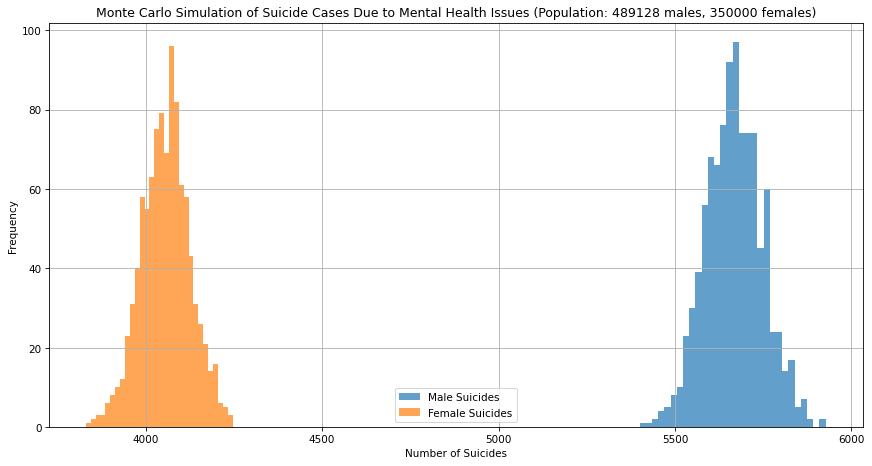

Average suicides in males: 5667.584
Average suicides in females: 4056.223


In [30]:
for pop_male, pop_female in state.populations:
  state.results_male = np.zeros(system.iterations, dtype=int)
  state.results_female = np.zeros(system.iterations, dtype=int)

  for i in range(system.iterations):
    suicide_male, suicide_female = run_simulation(state, system)
    state.results_male[i] = int(suicide_male)
    state.results_female[i] = int(suicide_female)

  state.results_total = state.results_male + state.results_female

  # Plotting hasil simulasi
  plt.figure(figsize=(14, 7))
  plt.hist(state.results_male, bins=30, alpha=0.7, label='Male Suicides')
  plt.hist(state.results_female, bins=30, alpha=0.7, label='Female Suicides')
  plt.xlabel('Number of Suicides')
  plt.ylabel('Frequency')
  plt.grid(True)
  plt.title(
    f'Monte Carlo Simulation of Suicide Cases Due to Mental Health Issues (Population: {pop_male} males, {pop_female} females)')
  plt.legend()
  plt.show()

  # Summary statistics
  mean_male = np.mean(state.results_male)
  mean_female = np.mean(state.results_female)
  print(f'Average suicides in males: {mean_male}')
  print(f'Average suicides in females: {mean_female}')

## Helper function untuk predict

1. `convert_arr_string_into_integer(arr)`
Fungsi ini digunakan untuk mengonversi setiap elemen dalam daftar dari string menjadi integer. Ini diperlukan ketika data awalnya dalam format string dan perlu diubah menjadi integer untuk analisis numerik.

In [31]:
# np.max(state.results_total)
state.results_male

array([5660, 5712, 5558, 5608, 5646, 5664, 5634, 5637, 5674, 5578, 5592,
       5680, 5629, 5660, 5683, 5642, 5726, 5667, 5712, 5688, 5568, 5701,
       5621, 5750, 5756, 5612, 5740, 5779, 5664, 5510, 5550, 5577, 5823,
       5798, 5657, 5827, 5694, 5561, 5740, 5682, 5732, 5636, 5670, 5670,
       5463, 5758, 5703, 5636, 5785, 5613, 5626, 5788, 5643, 5724, 5505,
       5615, 5673, 5549, 5615, 5630, 5632, 5626, 5633, 5659, 5547, 5829,
       5759, 5768, 5802, 5559, 5532, 5719, 5673, 5711, 5753, 5588, 5682,
       5636, 5559, 5746, 5664, 5534, 5663, 5608, 5747, 5675, 5581, 5636,
       5765, 5763, 5671, 5564, 5598, 5611, 5595, 5609, 5660, 5644, 5715,
       5504, 5669, 5763, 5635, 5832, 5622, 5650, 5782, 5582, 5712, 5714,
       5759, 5735, 5694, 5654, 5557, 5654, 5635, 5582, 5679, 5629, 5727,
       5789, 5793, 5698, 5693, 5569, 5682, 5666, 5652, 5663, 5617, 5586,
       5650, 5766, 5550, 5723, 5656, 5637, 5587, 5656, 5788, 5696, 5445,
       5669, 5621, 5859, 5677, 5712, 5701, 5740, 55

## Simulasi predict

f(x) = 0.000354334x + 5.66162

In [32]:
a = 0.000354334
b = 5.66162

In [33]:
def linear_predict(x):
  return a * x + b

## Function Helper

In [34]:
def convert_string_into_int(x):
  return [int(i) for i in x]

In [35]:
def run_predict(year, populasi, rentang):
  populate = np.linspace(populasi[0], populasi[1], rentang)
  tahun = year[1] - year[0]
  results = []
  
  for _ in range(tahun):
    temp = random.choice(populate)
    results.append(linear_predict(temp) * 1000)
    
  return results

In [36]:
# Input user
populasi = input("Masukan populasi eg(20000 40000): ")
year = input("Masukan rentang tahun eg(2000 3000): ")
rentang = int(input("Masukan rentang yang diinginkan untuk populasi: "))

total_populasi = convert_string_into_int(populasi.split(" "))
year_arr = convert_string_into_int(year.split(" "))

results_predict = run_predict(year_arr, total_populasi, rentang)

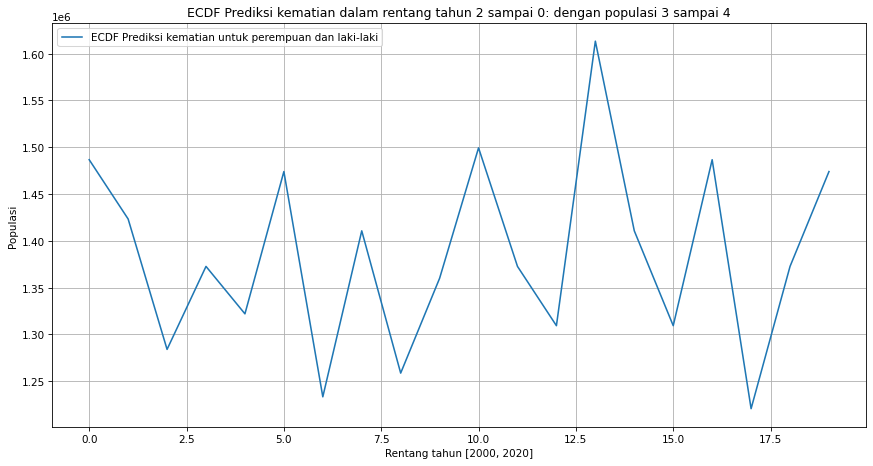

In [37]:
plt.figure(figsize=(14, 7))
plt.plot(results_predict, label='ECDF Prediksi kematian untuk perempuan dan laki-laki')
plt.xlabel(f'Rentang tahun {year_arr}')
plt.ylabel('Populasi')
plt.grid(True)
plt.title(f'ECDF Prediksi kematian dalam rentang tahun {year[0]} sampai {year[1]}: dengan populasi {populasi[0]} sampai {populasi[1]}')
plt.legend()
plt.show()